In [1]:
%matplotlib inline
import numpy as np
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
import scipy.stats as stats

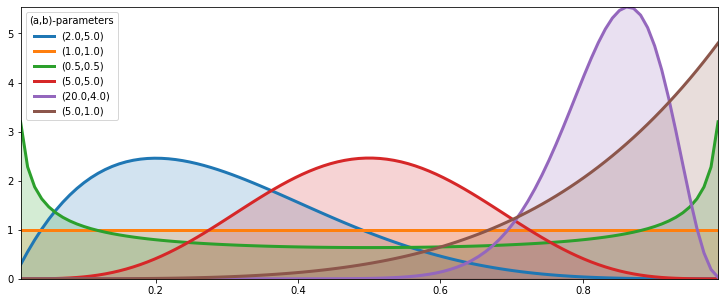

In [4]:
figsize(12.5, 5)

params = [(2, 5), (1, 1), (0.5, 0.5), (5, 5), (20, 4), (5, 1)]

x = np.linspace(0.01, .99, 100)
beta = stats.beta
for a, b in params:
    y = beta.pdf(x, a, b)
    lines = plt.plot(x, y, label="(%.1f,%.1f)" % (a, b), lw=3)
    plt.fill_between(x, 0, y, alpha=0.2, color=lines[0].get_color())
    plt.autoscale(tight=True)
plt.ylim(0)
plt.legend(loc='upper left', title="(a,b)-parameters");

In [6]:
!pip install pymc

     |████████████████████████████████| 385 kB 4.7 MB/s 
  Created wheel for pymc: filename=pymc-2.3.8-cp37-cp37m-linux_x86_64.whl size=1353146 sha256=cd289db67176612a6a9b367311c9b802bd063c32cff7ce4669c39afc4aba83af
  Stored in directory: /root/.cache/pip/wheels/3b/9b/1d/2a2ddbe80519db2698745f0988ce50c36ad38aac886a4ee0ca
Successfully built pymc


In [8]:
from pymc import rbeta

## representing N-armed bandits
class Bandits(object):
    def __init__(self, p_array):
        self.p = p_array
        self.optimal = np.argmax(p_array)

    def pull(self, i):
        # i is which arm to pull
        return np.random.rand() < self.p[i]

    def __len__(self):
        return len(self.p)


class BayesianStrategy(object):
    def __init__(self, bandits):

        self.bandits = bandits
        n_bandits = len(self.bandits)
        self.wins = np.zeros(n_bandits)
        self.trials = np.zeros(n_bandits)
        self.N = 0
        self.choices = []
        self.bb_score = []

    def sample_bandits(self, n=1):

        bb_score = np.zeros(n)
        choices = np.zeros(n)

        for k in range(n):
            # sample from the bandits's priors, and select the largest sample
            choice = np.argmax(rbeta(1 + self.wins, 1 + self.trials - self.wins))

            # sample the chosen bandit
            result = self.bandits.pull(choice)

            # update priors and score
            self.wins[choice] += result
            self.trials[choice] += 1
            bb_score[k] = result
            self.N += 1
            choices[k] = choice

        self.bb_score = np.r_[self.bb_score, bb_score]
        self.choices = np.r_[self.choices, choices]
        return

In [9]:
figsize(11.0, 10)

beta = stats.beta
x = np.linspace(0.001, .999, 200)


def plot_priors(bayesian_strategy, prob, lw=3, alpha=0.2, plt_vlines=True):
    # plotting function
    wins = bayesian_strategy.wins
    trials = bayesian_strategy.trials
    for i in range(prob.shape[0]):
        y = beta(1 + wins[i], 1 + trials[i] - wins[i])
        p = plt.plot(x, y.pdf(x), lw=lw)
        c = p[0].get_markeredgecolor()
        plt.fill_between(x, y.pdf(x), 0, color=c, alpha=alpha,
                         label="underlying probability: %.2f" % prob[i])
        if plt_vlines:
            plt.vlines(prob[i], 0, y.pdf(prob[i]),
                       colors=c, linestyles="--", lw=2)
        plt.autoscale(tight="True")
        plt.title("Posteriors After %d pull" % bayesian_strategy.N +
                  "s" * (bayesian_strategy.N > 1))
        plt.autoscale(tight=True)
    return

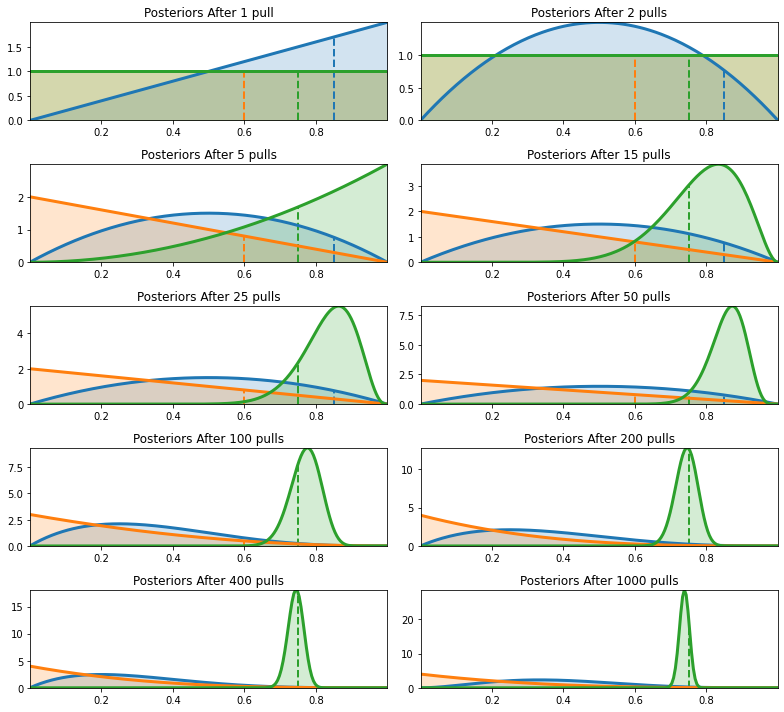

In [10]:
hidden_prob = np.array([0.85, 0.60, 0.75])
bandits = Bandits(hidden_prob)
bayesian_strat = BayesianStrategy(bandits)

draw_samples = [1, 1, 3, 10, 10, 25, 50, 100, 200, 600]

for j, i in enumerate(draw_samples):
    plt.subplot(5, 2, j + 1)
    bayesian_strat.sample_bandits(i)
    plot_priors(bayesian_strat, hidden_prob)
    # plt.legend()
    plt.autoscale(tight=True)
plt.tight_layout()